## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. In this project, our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

(https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, we should read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df[df['converted']==1].shape[0]/df.user_id.nunique()

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
selection1=df.loc[(df.group=='treatment')&(df.landing_page!='new_page')].count()+df.loc[(df.group!='treatment')&(df.landing_page=='new_page')].count()
selection1[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()[0]

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [12]:
df2=df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]
df2.shape

(290585, 5)

In [15]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [16]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [17]:
df2.nunique()[0]

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [18]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [19]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [ ]:
#df2.drop_duplicates(inplace=True)
#df2.user_id.duplicated().sum()
#df2.drop(df2.index[1899], inplace=True)  ????????????????????????????
#df2.user_id.duplicated().sum()
#df2[df2['user_id'].duplicated(keep=False)]

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [26]:
df[df['group']=='treatment']['converted'].mean()

0.11891957956489856

b. Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
df[df['group']=='control']['converted'].mean()

0.12039917935897611

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [27]:
df[df['group']=='treatment']['converted'].mean()

0.11891957956489856

d. What is the probability that an individual received the new page?

In [28]:
df[df['landing_page']=='new_page'].shape[0]/df.shape[0]

0.5

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

****Based on results above, the rate of conversion by old page is more than new page so, the old page should stay.**.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}=$  $p_{old}>p_{new}$ **

**$H_{1}=$  $p_{new}>p_{old}$ **

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [9]:
p_new=df.query('converted==1').user_id.count()/df.shape[0]
p_new

0.11965919355605512

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [10]:
p_old=df.query('converted==1').user_id.count()/df.shape[0]
p_old

0.11965919355605512

c. What is $n_{new}$?

In [31]:
n_new=df2[df['group']=='treatment'].user_id.nunique()
n_new

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


145310

d. What is $n_{old}$?

In [30]:
n_old=df2[df['group']=='control'].user_id.nunique()
n_old

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [32]:
tmp = df2[df['group']=='treatment'].sample(n_new, replace=True)
new_page_converted = tmp.converted

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [33]:
tmp = df2[df['group']=='control'].sample(n_old, replace=True)
old_page_converted = tmp.converted

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [34]:
pnew = new_page_converted.sum()/new_page_converted.count()
pold = old_page_converted.sum()/old_page_converted.count()
diff = pnew - pold

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [35]:
p_diffs = []
for _ in range(10000):
    tmp = df2[df['group']=='treatment'].sample(n_new, replace=True)
    new_page_converted = tmp.converted
    tmp = df2[df['group']=='control'].sample(n_old, replace=True)
    old_page_converted = tmp.converted
    pnew = new_page_converted.sum()/new_page_converted.count()
    pold = old_page_converted.sum()/old_page_converted.count()
    p_diffs.append(pnew-pold)
p_diffs

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


[-0.0013719117234282235,
 0.00012195550293038482,
 -0.0013785070597759075,
 -4.9940395025552253e-05,
 -0.0020874592457683777,
 -0.00099336113213963073,
 -0.00051810837454072112,
 -0.0014132095778798398,
 -0.0016332578831642908,
 -0.0010413873419473502,
 -0.0015575525399478957,
 -0.0005527904281818069,
 -0.0043998832892736123,
 0.00052105610987442097,
 -0.0011513893247548368,
 -0.0010004731961738289,
 0.00013541391901447652,
 -0.0027067599360961897,
 -0.0012546476038591131,
 -0.0031612000507666577,
 -0.0029546340367729296,
 -0.00029149031348711663,
 -0.00097932971109625233,
 -0.0015505956647568347,
 -0.0010482760022623022,
 -0.0016398327550491421,
 -0.00020862003970754939,
 -0.003147542106169951,
 -0.0028239609569049029,
 -0.0034088916766498167,
 -0.0025484810538113079,
 -0.0029272055930339436,
 -0.00076580852728339033,
 1.1544230866272764e-05,
 -0.0012205931270781872,
 -0.0028515616432060603,
 -0.0040079663719836678,
 -0.00082821746474644187,
 -0.0025966641578340499,
 0.000872014541721

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

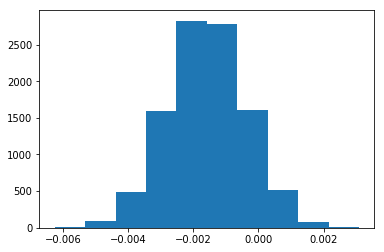

In [36]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [ ]:
pold_actual = df[df['group']=='control']['converted'].mean()
pnew_actual = df[df['group']=='treatment']['converted'].mean()
p_diff_actual = pnew_actual - pold_actual
print((p_diffs>p_diff_actual).mean())

In [ ]:
p_diffs = np.array(p_diffs)
nulls = np.random.normal(0,p_diffs.std(),p_diffs.size)
plt.hist(nulls);
plt.axvline(x=p_diff_actual, color='red')

In [ ]:
(nulls>p_diff_actual).mean()

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

****We have computed the p-value which we can use to assess if the obtained negative c_diff is statistically significant. A negative c_diff proves that null hypothesis is valid based on our definition of null (New is not better). Initially, after bootstrapping we obtained a distribution for c_diff centered at -0.001 which tends to show that null is valid. But, comparing that to null random normal distribution shows that there is a high chance that this negative value is drawn from a null random process (large p-value). Therefore, this negative value for c_diff is not statistically significant. Thus, null is rejected and  New is better.**.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [ ]:
import statsmodels.api as sm

convert_old = df2[(df2['group']=='control')&(df2['converted']==1)]['user_id'].count()
convert_new = df2[(df2['group']=='treatment')&(df2['converted']==1)]['user_id'].count()
n_old = df2[df2['group']=='control'].user_id.nunique()
n_new = df2[df2['group']=='treatment'].user_id.nunique()

In [ ]:
convert_old,convert_new,n_old,n_new

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [ ]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old,n_new],value=None, alternative='smaller', prop_var=False)
print(z_score,p_value)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The obtained p-value (.894) agrees with what we obtained in part j (.890) indicatig that the null hypothesis (New not better) is rejected. z-score is the number of standard deviations the observed conversion rate is away from the mean. This agrees with the conclusion we made in part k **

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Here we should try  linear regression bacause we have just two quantitative data to compare.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [ ]:
df2[['control','ab_page']]=pd.get_dummies(df2['group'])
df2.head()

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [ ]:
df2['intercept']=1
model=sm.OLS(df2['converted'],df2[['intercept','ab_page']])
result=model.fit()

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [ ]:
result.summary()

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**In our regression model, the null hypothesis is that the coefficient of ab_page is nagative. This means that, under null, an increase in ab_page (using new page) results in decrease of conversion. In other words, under null, new page is NOT better:**

$H_{0}: $  $coeff_{ab- page}<0$

**Fitting a linear model with OLS, we obtain this coefficient to be -0.0015 which tends to show that null is valid. But, the p-value associated with this coefficient is large (0.216) which shows that the negative coefficient obtained for ab_page is not statistically significant. Therefore, null is rejected, and new page is better **

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Here we used only one variable (membership in control or treatment groups) to draw a conclusion about the conversion rate. In real life, there might be other effective parameters for example gender of user, age, etc. Current dataset does not contain this information, but adding them may help to draw a better conclusion. A possible disadvantage is that if more variables are going to be added, more data points should be collected as well to maintain a reach dataset. Moreover, adding new variables should be done cauciously to avoid adding correlated variables that violates the assumptions of linear regression. **

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [ ]:
df_country=pd.read_csv('countries.csv')
df_country.country.unique()

In [ ]:
df2=df2.set_index('user_id').join(df_country.set_index('user_id'))

In [ ]:
df2[['US','UK','CA']]=pd.get_dummies(df2['country'])
df2.head()

In [ ]:
df2['intercept']=1
model=sm.OLS(df2['converted'],df2[['intercept','US','UK']])
result=model.fit()
result.summary()

**Based on the result we se that US has the negative impact on conversion rate and UK has positive impact, but amount of p-values in both show that the coefficients are not stastically significant  **

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [ ]:
df2[['control','ab_page']]=pd.get_dummies(df2['group'])


In [ ]:
model=sm.OLS(df2['converted'],df2[['intercept','US','UK','ab_page']])
result=model.fit()
result.summary()

**Here we see that based on our model ab_page and US have negative impact in our conversion rate and UK has positive effect, but by looking at the p_value we find that our results are not statistically significant **

<a id='conclusions'></a>
## Conclusions

**This project is a sample of Simpson's Paradox, because by the first glimpse on the data, we can conclude that the conversion rate of old page is more than new page  so it is better to stay. 
But by doing haypothesis testing and regression model we can see completely different result and based on them we can conclude that the new page has better results.**
### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.